### 1. CC applications
<p>In this notebook, we will build an automatic credit card approval predictor using machine learning techniques - To Replace: - Manually analyzing these applications is mundane, error-prone, and time-consuming. </p>

<p>We'll use the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">CC Approval dataset</a> from the UCI Machine Learning Repository.</p>
<ul>
<li>We will see that the dataset has a mixture of both numerical and non-numerical features, that it contains values from different ranges, plus that it contains a number of missing entries.</li>
<li>We will have to preprocess the dataset to ensure the machine learning model we choose can make good predictions.</li>
<li>After our data is in good shape, we will do some exploratory data analysis to build our intuitions.</li>
<li>Finally, we will build a machine learning model that can predict if an individual's application for a credit card will be accepted.</li>
</ul>
<p>First, loading and viewing the dataset. We find that since this data is confidential, the contributor of the dataset has anonymized the feature names.</p>

In [196]:
import pandas as pd    
import numpy as np

## load dataset
df = pd.read_csv("cc_approvals.data",header=None)
df = df.rename(columns={0:'col1',1:'col2',2:'col3',3:'col4',4:'col5',5:'col6',6:'col7',7:'col8',8:'col9',9:'col10',10:'col11',11:'col12',12:'col13',13:'col14',14:'col15',15:'col16'})

df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


After my researching in the field, we now rename all columns within the dataset.

In [197]:
df = df.rename(columns={'col1':'Gender','col2':'Age','col3':'Debt','col4':'Married','col5':'BankCustomer','col6':'EducationalLevel','col7':'Ethnicity','col8':'YearsEmployed','col9':'PriorDefault','col10':'Employed','col11':'CreditScore','col12':'DriversLicense','col13':'Citizen','col14':'ZipCode','col15':'Income','col16':'Approved'})
print(df.shape)
df.tail()

(690, 16)


,Gender,Age,Debt,Married,BankCustomer,EducationalLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-
689,b,35.00,3.375,u,g,c,h,8.29,f,f,0,t,g,00000,0,-


### 2. Inspecting the applications
<p>As we can see, the dataset has a mixture of numerical and non-numerical features. This can be fixed with some preprocessing. Let's learn about the dataset a bit more to see if there are other dataset issues that need to be fixed.</p>

In [198]:
## summary statistics & info:

dat_description = df.describe()
print(dat_description)

print("\n")

dat_info = df.info()
print(dat_info)


             Debt  YearsEmployed  CreditScore         Income
count  690.000000     690.000000    690.00000     690.000000
mean     4.758725       2.223406      2.40000    1017.385507
std      4.978163       3.346513      4.86294    5210.102598
min      0.000000       0.000000      0.00000       0.000000
25%      1.000000       0.165000      0.00000       0.000000
50%      2.750000       1.000000      0.00000       5.000000
75%      7.207500       2.625000      3.00000     395.500000
max     28.000000      28.500000     67.00000  100000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
Gender              690 non-null object
Age                 690 non-null object
Debt                690 non-null float64
Married             690 non-null object
BankCustomer        690 non-null object
EducationalLevel    690 non-null object
Ethnicity           690 non-null object
YearsEmployed       690 non-null float64
PriorDefault        69

In [199]:
# num_cols = ['Debt','YearsEmployed','CreditScore','Income']
## convert numerical data
# df[num_cols] = df[num_cols].apply(pd.to_numeric,errors='coerce')
# df.info()

In [200]:
##
nonum_cols = df.columns.drop('Approved').drop(num_cols)
nonum_cols

Index(['Gender', 'Age', 'Married', 'BankCustomer', 'EducationalLevel',
       'Ethnicity', 'PriorDefault', 'Employed', 'DriversLicense', 'Citizen',
       'ZipCode'],
      dtype='object')

In [201]:
## check the number of unique values...later on we'll convert the values using get-dummies method
df[nonum_cols].apply(lambda x: x.nunique(), axis=0)

Gender                3
Age                 350
Married               4
BankCustomer          4
EducationalLevel     15
Ethnicity            10
PriorDefault          2
Employed              2
DriversLicense        2
Citizen               3
ZipCode             171
dtype: int64

In [202]:
## convert target variables into '0' and '1':

## convert categorical target to numerical
df['Approved'] = df['Approved'].apply(lambda x: 1 if x=='+' else 0)

## show the head of df['class']
df['Approved'].head()

0    1
1    1
2    1
3    1
4    1
Name: Approved, dtype: int64

### 3. The missing values handling
<p>Some uncovered issues that will affect the performance of our machine learning model(s) if going unchanged:</p>
<ul>
<li>The dataset contains both numeric and non-numeric data (specifically data that are of <code>float64</code>, <code>int64</code> and <code>object</code> types).</li>
<li>The dataset also contains values from several ranges. Some features have a value range of 0 - 28, some have a range of 2 - 67, and some have a range of 1017 - 100000. Apart from these, we can get useful statistical information (like <code>mean</code>, <code>max</code>, and <code>min</code>) about the features that have numerical values. </li>
<li>Finally, the dataset has missing values, which we'll take care of in this task. The missing values in the dataset are labeled with '?', which can be seen in the last cell's output.</li>
</ul>
<p>Now, let's first replace these missing value question marks with NaN.</p>

In [203]:

print(df.isnull().sum())

## replace the '?'s with NaN
cdat = df.replace('?',np.nan)
print('\n')
## inspect the missing values again
print(cdat.isnull().sum())

Gender              0
Age                 0
Debt                0
Married             0
BankCustomer        0
EducationalLevel    0
Ethnicity           0
YearsEmployed       0
PriorDefault        0
Employed            0
CreditScore         0
DriversLicense      0
Citizen             0
ZipCode             0
Income              0
Approved            0
dtype: int64


Gender              12
Age                 12
Debt                 0
Married              6
BankCustomer         6
EducationalLevel     9
Ethnicity            9
YearsEmployed        0
PriorDefault         0
Employed             0
CreditScore          0
DriversLicense       0
Citizen              0
ZipCode             13
Income               0
Approved             0
dtype: int64


<p>As we know, ignoring missing values can affect the performance of a machine learning model heavily. While ignoring the missing values our machine learning model may miss out on information about the dataset that may be useful for its training. Then, there are many models which cannot handle missing values implicitly such as LDA. </p>
<p>To avoid this problem, let's impute the missing values with a strategy called mean imputation.</p>

In [204]:
## impute the missing values with mean imputation
cdat.fillna(cdat.mean(), inplace=True)

## count the number of NaNs in the dataset to verify
cdat.isnull().sum()

Gender              12
Age                 12
Debt                 0
Married              6
BankCustomer         6
EducationalLevel     9
Ethnicity            9
YearsEmployed        0
PriorDefault         0
Employed             0
CreditScore          0
DriversLicense       0
Citizen              0
ZipCode             13
Income               0
Approved             0
dtype: int64

In [205]:
cdat.head()

,Gender,Age,Debt,Married,BankCustomer,EducationalLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1


<p>There are still some missing values to be imputed for the columns such as Gender, ZipCode, etc. All of these columns contain non-numeric data and this why the mean imputation strategy would not work here.</p>
<p>We need a different treatment so let's impute these missing values with the most frequent values as present in the respective columns (and this is a good practice as to imputing missing values for categorical data in general)</p>

In [206]:
print(df['Age'].value_counts())
print('\n')
print(df['ZipCode'].value_counts())

?        12
22.67     9
20.42     7
25.00     6
22.50     6
         ..
54.33     1
30.00     1
46.00     1
27.17     1
39.25     1
Name: Age, Length: 350, dtype: int64


00000    132
00200     35
00120     35
00160     34
00080     30
        ... 
00395      1
00093      1
00519      1
00188      1
00434      1
Name: ZipCode, Length: 171, dtype: int64


In [207]:
## irate over each column
for col in cdat.columns:
    if cdat[col].dtype == 'object':
                                   ## impute with the most frequent value..cdat.fillna(df['Age'].value_counts().index[0])
        cdf = cdat.fillna(df[col].value_counts().index[0])


        
## count the number of NaNs in the dataset and print the counts to verify
cdf.isnull().sum()

Gender              0
Age                 0
Debt                0
Married             0
BankCustomer        0
EducationalLevel    0
Ethnicity           0
YearsEmployed       0
PriorDefault        0
Employed            0
CreditScore         0
DriversLicense      0
Citizen             0
ZipCode             0
Income              0
Approved            0
dtype: int64

### 4. Preprocessing the data 
<p>There is still some minor but essential data preprocessing needed before we proceed towards building our machine learning model. Let's divide these remaining preprocessing steps:</p>
<ol>
<li>Convert the non-numeric data into numeric.</li>
<li>Split the data into train and test sets. </li>
<li>Scale the feature values to a uniform range.</li>
</ol>
<p>We will be converting all the non-numeric values into numeric ones. We do this because not only it results in a faster computation but also many machine learning models (like XGBoost) (and especially the ones developed using scikit-learn) require the data to be in a strictly numeric format.</p>

Features like DriversLicense and ZipCode are not as important as the other features in the dataset for predicting credit card approvals, So let's drop them to design our machine learning model with the best set of features.

In [208]:
cdf.drop(['DriversLicense','ZipCode'],axis=1,inplace=True)
cdf.tail()

,Gender,Age,Debt,Married,BankCustomer,EducationalLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,g,0,0
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,g,394,0
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,g,1,0
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,g,750,0
689,b,35.00,3.375,u,g,c,h,8.29,f,f,0,g,0,0


In [209]:
## X & y
X = cdf.drop(columns=['Approved'])
y= cdf['Approved']

In [210]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Approved, dtype: int64

In [211]:
## check the number of unique values before getting dummies
X.apply(lambda x: x.nunique(), axis=0)

Gender                3
Age                 350
Debt                215
Married               4
BankCustomer          4
EducationalLevel     15
Ethnicity            10
YearsEmployed       132
PriorDefault          2
Employed              2
CreditScore          23
Citizen               3
Income              240
dtype: int64

The get-dummies method

In [212]:
## get dummies
Xmy = pd.get_dummies(X, prefix_sep='_', drop_first=True)
Xmy.head()

,Debt,YearsEmployed,CreditScore,Income,Gender_a,Gender_b,Age_13.75,Age_15.17,Age_15.75,Age_15.83,...,Ethnicity_h,Ethnicity_j,Ethnicity_n,Ethnicity_o,Ethnicity_v,Ethnicity_z,PriorDefault_t,Employed_t,Citizen_p,Citizen_s
0,0.000,1.25,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
1,4.460,3.04,6,560,1,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
2,0.500,1.50,0,824,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,1.540,3.75,5,3,0,1,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
4,5.625,1.71,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1


Let's do cross-validation for the new dataset we just obtained. 

In [213]:
## XGB
import xgboost as xgb
from sklearn.model_selection import cross_val_score

## instantiate XGBClassifier
xgb_cl = xgb.XGBClassifier()

## cross validation score
cv_scores = cross_val_score(xgb_cl, Xmy, y, scoring='roc_auc', cv=45)

In [214]:
## print out the mean cross validation score
print('45-fold AUC: {}'.format(np.mean(cv_scores)))

45-fold AUC: 0.9427689594356262


### 5. Splitting the dataset into train and test sets
<p>Now, let's split our data into train set and test set to prepare our data for two different phases of machine learning modeling: training and testing. Ideally, no information from the test data should be used to scale the training data or should be used to direct the training process of a machine learning model.</p>

In [215]:
from sklearn.model_selection import train_test_split

## split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xmy, y, test_size=0.2, random_state=42)

To continue the data-preprocessing: 
Let's use <code>CreditScore</code> as an example. The credit score of a person is their creditworthiness based on their credit history. The higher this number, the more financially trustworthy a person is considered to be. So, a <code>CreditScore</code> of 1 is the highest since we're rescaling all the values to the range of 0-1.</p>

In [216]:
from sklearn.preprocessing import MinMaxScaler

## instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))

rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

### 6. Fitting a logistic regression model, making predictions and evaluating performance
<p>Essentially, predicting if a credit card application will be approved or not is a classification task. The dataset contains more instances that correspond to "Denied" status than instances corresponding to "Approved" status. Specifically, out of 690 instances, there are 383 (55.5%) applications that got denied and 307 (44.5%) applications that got approved. </p>
<p>This gives us a benchmark of which a good machine learning model should be able to accurately predict the status of the applications with respect to these statistics.</p>
<p>In the case of predicting credit card applications, it is equally important to see if our machine learning model is able to predict the approval status of the applications as denied that originally got denied. If our model is not performing well in this aspect, then it might end up approving the application that should have been approved. The confusion matrix helps us to view our model's performance from these aspects.</p>

In [217]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

## predict instances from the test set and store it
y_pred = logreg.predict(X_test)

## get the accuracy score 
print("Accuracy of logistic regression classifier: ", accuracy_score(y_pred, y_test))

## the confusion matrix of the logreg model
confusion_matrix(y_pred, y_test)

Accuracy of logistic regression classifier:  0.8333333333333334


C:\Users\bista\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[56, 11],
       [12, 59]], dtype=int64)

### 7. Grid searching and making the model perform better
<p>Our model was able to yield an accuracy score of almost 84%.</p>
<p>For the confusion matrix, the first element of the of the first row of the confusion matrix denotes the true negatives meaning the number of negative instances (denied applications) predicted by the model correctly. And the last element of the second row of the confusion matrix denotes the true positives meaning the number of positive instances (approved applications) predicted by the model correctly.</p>
<p>Let's see if we can do better - using GridSearchCV. We will define the grid of hyperparameter values and converted them into a single dictionary format which GridSearchCV() expects as one of its parameters. We will instantiate GridSearchCV() with our logreg model with all the data we have. Instead of passing train and test sets separately, we will supply X (scaled version) and y. We will also instruct GridSearchCV() to perform a cross-validation of 40 folds.</p>

In [218]:
from sklearn.model_selection import GridSearchCV

# alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

## define the grid of values for tol and max_iter
tol = [1, 0.5, 0.3, 0.1]
max_iter = [1000, 800, 200, 100]

## create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = dict([('tol', tol), ('max_iter', max_iter)])

## instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=45)

## use scaler to rescale X and assign it to rescaledX
rescaledX = scaler.fit_transform(Xmy)
grid_model_result = grid_model.fit(rescaledX, y)

## summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.859537 using {'max_iter': 1000, 'tol': 0.5}


### 8. XGBoost classification & ROC curve

In [219]:
## fit the model
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [220]:
## predict on the test set
y_pred_prob = xgb_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [221]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.9109243697478993


The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

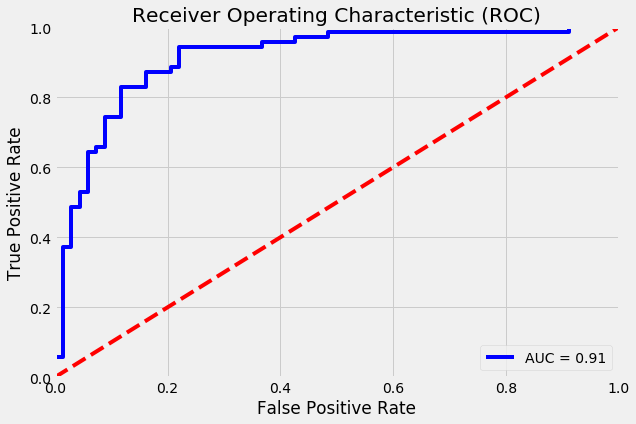

In [222]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Figure size 720x576 with 0 Axes>

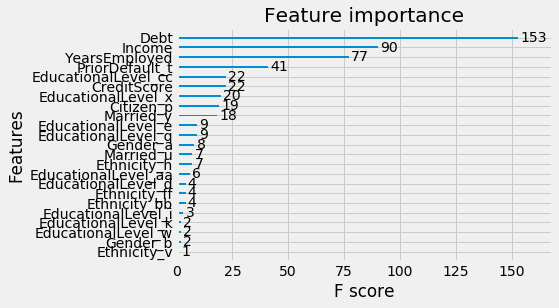

In [223]:
##
plt.figure(figsize=(10,8))

## styple
plt.style.use('fivethirtyeight')

## plotting feature importance
xgb.plot_importance(xgb_cl)